In [1]:
suppressPackageStartupMessages(suppressWarnings({
    library("ggplot2")
    library(dplyr)
    library(tidyr)
    library(ComplexHeatmap)
    library(tibble)
    library(RColorBrewer)
    library(circlize)
}))


In [2]:
# show all columns
options(repr.matrix.max.cols=200, repr.matrix.max.rows=100)

In [3]:
profile_path <- file.path("../../data/CP_scDINO_features/combined_CP_scDINO_norm_fs.parquet")
figure_path <- file.path("../figures/")
if (!dir.exists(figure_path)) {
    dir.create(figure_path, recursive = TRUE)
}
df <- arrow::read_parquet(profile_path)
# get the metadata columns only 
metadata_df <- df %>% 
  select(contains("Metadata"))

metadata_df$unique_cell <- paste0(
    metadata_df$Metadata_track_id, "_", 

    metadata_df$Metadata_Well, "_", 
    metadata_df$Metadata_FOV, "_", 
    metadata_df$Metadata_dose
    )
# sort by Metadata_Well
metadata_df <- metadata_df %>% 
  arrange(Metadata_Well, Metadata_FOV, Metadata_dose)
head(metadata_df,1)

Metadata_plate,Metadata_Well,Metadata_number_of_singlecells,Metadata_compound,Metadata_dose,Metadata_control,Metadata_ImageNumber,Metadata_FOV,Metadata_Time,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_ImageNumber_1,Metadata_ImageNumber_2,Metadata_ImageNumber_3,Metadata_Nuclei_Number_Object_Number,Metadata_Image_FileName_CL_488_1,Metadata_Image_FileName_CL_488_2,Metadata_Image_FileName_CL_561,Metadata_Image_FileName_DNA,Metadata_Image_PathName_CL_488_2,Metadata_Image_PathName_CL_561,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_coordinates_x,Metadata_track_id,Metadata_t,Metadata_y,Metadata_x,Metadata_id,Metadata_parent_track_id,Metadata_parent_id,Metadata_coordinates_y,Metadata_distance,Metadata_image_path,unique_cell
<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<list<double>>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<list<double>>,<dbl>,<chr>,<chr>
1,C-02,180,Staurosporine,0.0,negative,1,0001,0.0,101,101,100,1,1,1,100.0,C-02_F0001_T0001_Z0001_C02_illumcorrect.tiff,C-02_F0001_T0001_Z0001_C03_illumcorrect.tiff,C-02_F0001_T0001_Z0001_C04_illumcorrect.tiff,C-02_F0001_T0001_Z0001_C01_illumcorrect.tiff,/gpfs/alpine1/scratch/mlippincott@xsede.org/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-02_F0001,/gpfs/alpine1/scratch/mlippincott@xsede.org/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-02_F0001,1583.286,1078.899,"1583.286, 1078.899",17,0,1079,1583,1000096,-1,-1,"1583, 1079",0.3037024,../0.pre-process_images/data/processed_images/sc_crops/C-02_F0001_time_0.0_image_number_1_cell_number_100.0/C-02_F0001_T0001_Z0001_C01_illumcorrectimage_number_1_cell_number_100.0_crop.tiff,17_C-02_0001_0.0


In [4]:
plotting_df <- metadata_df %>% 
  select(c(
    "Metadata_Time", 
    "Metadata_dose", 
    "unique_cell"
    ))
plotting_df$values <- 1
plotting_df <- plotting_df %>% 
  select(-Metadata_dose)
# pivot wide such that the Metadata_id in the columns
plotting_df <- plotting_df %>% 
  pivot_wider(
    names_from = unique_cell,
    values_from = values
  )

In [5]:
# get the well names by splitting the column names by _
well_names <- plotting_df %>% 
  select(-Metadata_Time) %>% 
  colnames() %>% 
  strsplit("_") %>% 
  sapply(function(x) x[2]) %>%
  as.data.frame() %>%
  rename(Metadata_Well = ".") 
well_dose <- df %>% 
  select(c("Metadata_dose", "Metadata_Well")) %>%
  distinct() 
well_names <- well_names %>%
    left_join(well_dose, by = "Metadata_Well") %>% 
    select(-Metadata_Well)
well_names$Metadata_dose <- factor(
    well_names$Metadata_dose, 
    levels = c(
        "0", "0.61", "1.22", "2.44", "4.88", 
        "9.76", "19.53", "39.06", "78.13", "156.25"
    )
)
row_ha <- rowAnnotation(
    Dose = well_names$Metadata_dose,
    
    annotation_legend_param = list(
        title_position = "topcenter", 
        title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
        labels_gp = gpar(fontsize = 16, 
        # make annotation bar text bigger
        legend = gpar(fontsize = 16),
        annotation_name = gpar(fontsize = 16),
        legend_height = unit(20, "cm"),
        legend_width = unit(1, "cm"),
        # make legend taller
        legend_height = unit(10, "cm"),
        legend_width = unit(1, "cm"),
        legend_key = gpar(fontsize = 16)
        )
    ),

    col = list(
        Dose = c(
            "0" = "#57F2F2",
            "0.61" = "#63D6D6",
            "1.22" = "#65BABA",
            "2.44" = "#68A3A3",
            "4.88" = "#668A8A",
            "9.76" = "#5E7070",
            "19.53" = "#4B5757",
            "39.06" = "#2F3D3D",
            "78.13" = "#182424",
            "156.25" = "#030A0A"
        )
    ),


        
    annotation_name_side = "bottom",
    # make font size bigger
    annotation_name_gp = gpar(fontsize = 16)
    
)

In [6]:
# replace NA with 0
plotting_df[is.na(plotting_df)] <- 0 
# turn the values into characters
plotting_df <- plotting_df %>% 
  mutate(across(where(is.numeric), as.character))

In [7]:
# remove the Metadata_Time column
mat <- t(as.matrix(plotting_df))
colnames(mat) <- plotting_df$Metadata_Time
# drop the first row
mat <- mat[-1,]


In [8]:
# add another column that is the sum of the columns
mat <- as.data.frame(mat)
# convert from character to numeric
mat <- mat %>% 
  mutate(across(where(is.character), as.numeric))
# add a column that is the sum of the columns
mat$sum <- rowSums(mat)
# remove the last column
# sort the matrix by the sum column
mat <- mat %>% 
  arrange(desc(sum))
# remove the last column
mat <- mat %>% 
  select(-c("sum"))
# make the values character
mat <- mat %>% 
  mutate(across(where(is.numeric), as.character))
# convert to a matrix
mat <- as.matrix(mat)


In [9]:

# make 0 in the matrix Cell Absent and 1 Cell Present but not in the row names or column names
mat[mat == 0] <- "Cell Absent"
mat[mat == 1] <- "Cell Present"

colors = structure(
    c("#c8c8c8","#2a2a2a"), 
    names = c("Cell Absent", "Cell Present")
)

png 
  2

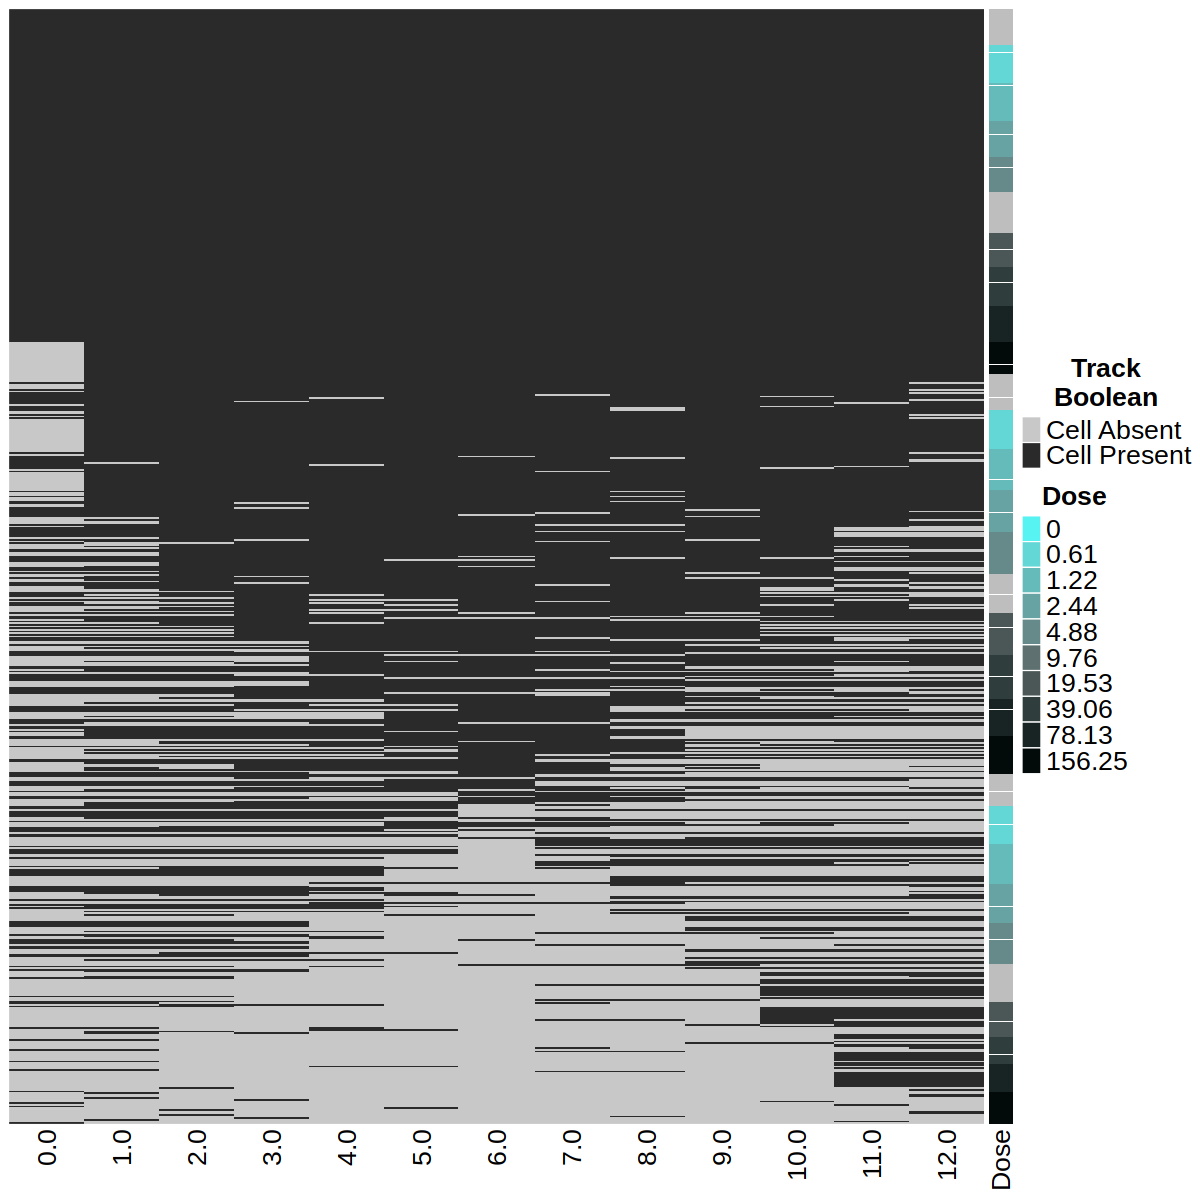

In [10]:
width <- 10
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
ht_opt$message = FALSE
heatmap <- Heatmap(
    mat, 
        cluster_rows = TRUE,    # Cluster rows
        cluster_columns = TRUE, # Cluster columns
        show_row_names = FALSE,  # Show row names
        show_column_names = TRUE, # Show column names
        column_names_gp = gpar(fontsize = 16), # Column name label formatting
        row_names_gp = gpar(fontsize = 14),    # Row name label formatting
        right_annotation = row_ha,
    
    heatmap_legend_param = list(
                title = "Track\nBoolean",
                title_position = "topcenter", 
                title_gp = gpar(fontsize = 16, angle = 0, fontface = "bold", hjust = 0.5),
                labels_gp = gpar(fontsize = 16),
                legend_height = unit(6.6, "cm")
                ),
        column_dend_height = unit(4, "cm"), 
        row_dend_width = unit(4, "cm"),
        # set color for 0 and 1
        col = colors,
    
)

png(filename = paste0(figure_path, "cell_tracks_over_time_heatmap.png"), width = width, height = height, units = "in", res = 600)
heatmap
dev.off()
heatmap